In [51]:
#%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import h5py
from astropy.cosmology import Planck15 as cosmo
from astropy.cosmology import FlatLambdaCDM, z_at_value
import astropy.units as u
import scipy.constants as const

#cosmological parameters from simulation
myfile1='/cosma7/data/Eagle/ScienceRuns/Planck1/L0100N1504/PE/REFERENCE/data/groups_012_z003p017/eagle_subfind_tab_012_z003p017.0.hdf5'
myfile = h5py.File(myfile1, 'r')
H_const = myfile['Header'].attrs['HubbleParam']
Omega0 = myfile['Header'].attrs['Omega0']
z_sim = myfile['Header'].attrs['Redshift']
myfile.close()
cosmo = FlatLambdaCDM(H0 = H_const*100, Om0 = Omega0)

#reading from Pos_lumfun where the data from the "corrected LF" are stored
Pos_Mpc_corr = np.genfromtxt('Pos_lumfun.txt', usecols=(0,1,2))
L_lya_corr = np.genfromtxt('Pos_lumfun.txt', usecols=(3))

In [52]:
#####################
#FUNCTIONS#
#####################

def Length_box(lim_inf, lim_sup):
    """ Length of the squared box [cMpc]"""
    return np.abs(lim_sup-lim_inf)

def total_volume(lim_inf, lim_sup):
    """Volume of the squared box [cMpc^3]"""
    return np.abs((Length_box(lim_inf, lim_sup))**3)

def corr_func(Nrand, bins, Pos, lim_inf, lim_sup, verb):
    """    
    Parameters:
    -----------------
    Nrand   : int
        The number of random galaxies of which it computes the density profile
    bins    : numpy array (1D)
        The bins in cMpc of projected distance
    Pos     : numpy array (3D)
        The first two entries must be the projected positions of all the galaxies to consider
    lim_inf : float 
        The lower limit of the box we want to consider (useful if we are testing this function)
    lim_sup : float 
        The higher limit of the box we want to consider
    verb    : bool
        If True it prints some indications on the processes (useful to check the time each function is taking)
        
    Returns:
    -----------------
    bins_cen : numpy array
        The center of the bins in cMpc
    xi : numpy array
        The values of the correlation function
    """
    import numpy as np
    #selecting only galaxies in the box delimited by lim_inf and lim_sup
    if lim_inf != 0 and lim_sup != 100:
        ind = []
        for i in range(len(Pos)):
            if lim_inf<Pos[i,0]<lim_sup and lim_inf<Pos[i,1]<lim_sup and lim_inf<Pos[i,2]<lim_sup:
                ind.append('True')
            else:
                ind.append('False')
        ind = np.array(ind)
        Pos = Pos[ind=='True'][:]
    else:
        Pos = Pos
    
    random_gal = np.random.randint(0, len(Pos), Nrand) #random galaxies indices
    L_box = Length_box(lim_inf, lim_sup)
    tot_vol = total_volume(lim_inf, lim_sup)
    
    Ngal = len(Pos)
    if verb==True:
        print('The number of galaxies in side the considered volume is: ', Ngal)
    
    Nbins = len(bins)-1                                        
    bins_cen = (bins[1:]+bins[:-1])/2 
    dvol = 4/3*np.pi*(bins[1:]**3 - bins[:-1]**3)
    
    #print('Evaluating distances...')
    #distances between the selected random galaxies and all the others
    dd = np.zeros((Nrand,len(Pos)))
    for i,j in enumerate(random_gal):
        delta_c = np.abs(Pos[j] - Pos)
        delta_c = np.where(delta_c>L_box/2, np.abs(delta_c -L_box), delta_c) 
        dd[i] = np.sqrt(np.sum(delta_c**2, axis=1))
    
    if verb ==True:
        print('Counting elements inside the bins...')
        
    #number of galaxies in each bin
    dens_prof = np.zeros((Nrand, Nbins))
    for i in range(Nrand):
        dens_prof[i], _=np.histogram(dd[i], bins=bins)
    
    #normalizing by the volume
    dens_prof = dens_prof/dvol
    
    #average density profile
    av_dens_prof = np.mean(dens_prof, axis=0)
    err_dens_prof = 1/Nrand*np.sqrt(np.sum((dens_prof/dvol), axis=0))
    
    #getting xi as the mean density for each bin over the total average density - 1
    xi = av_dens_prof/(Ngal/tot_vol) -1
    err_xi = err_dens_prof/(Ngal/tot_vol)
    
    return bins_cen, xi, err_xi

def proj_corr_func(Nrand, bins, Pos, lim_inf, lim_sup, verb):
    """    
    Parameters:
    -----------------
    Nrand   : int
        The number of random galaxies of which it computes the density profile
    bins    : numpy array (1D)
        The bins in cMpc of projected distance
    Pos     : numpy array (3D)
        The first two entries must be the projected positions of all the galaxies to consider
    lim_inf : float 
        The lower limit of the box we want to consider (useful if we are testing this function)
    lim_sup : float 
        The higher limit of the box we want to consider
    verb    : bool
        If True it prints some indications on the total number of galaxies and on the processes the code is working on
    
    Returns:
    -----------------
    bins_cen : numpy array
        The center of the bins in cMpc
    xi : numpy array
        The values of the projected correlation function
    """
    if lim_inf != 0 and lim_sup != 100:
        ind = []
        for i in range(len(Pos)):
            if lim_inf<Pos[i,0]<lim_sup and lim_inf<Pos[i,1]<lim_sup and lim_inf<Pos[i,2]<lim_sup:
                ind.append('True')
            else:
                ind.append('False')
        ind = np.array(ind)
        Pos = Pos[ind=='True'][:]
    else:
        Pos = Pos
    
    random_gal = np.random.randint(0, len(Pos), Nrand) #random galaxies indices
    L_box = Length_box(lim_inf, lim_sup)
    tot_vol = L_box**2
    
    Ngal = len(Pos)
    if verb==True:
        print('The number of galaxies in side the considered volume is: ', Ngal)
    
    Nbins = len(bins)-1                                        
    bins_cen = (bins[1:]+bins[:-1])/2 
    dvol = np.pi*(bins[1:]**2-bins[:-1]**2)*L_box #cilindrical volume for each bin
    
    if verb==True:
        print('Evaluating distances...')
        
    #distances between the selected random galaxies and all the others
    dd = np.zeros((Nrand,len(Pos)))
    for i,j in enumerate(random_gal):
        delta_c = np.abs(Pos[j] - Pos)
        delta_c = np.where(delta_c>L_box/2, np.abs(delta_c -L_box), delta_c) 
        dd[i] = np.sqrt(np.sum(delta_c**2, axis=1))
    
    if verb==True:
        print('Counting elements inside the bins...')
        
    #number of galaxies in each bin
    dens_prof = np.zeros((Nrand, Nbins))
    for i in range(Nrand):
        dens_prof[i], _=np.histogram(dd[i], bins=bins)
    
    #normalizing by the volume
    dens_prof = dens_prof/dvol
    
    #average density profile
    av_dens_prof = np.mean(dens_prof, axis=0)
    err_dens_prof = 1/Nrand*np.sqrt(np.sum((dens_prof/dvol), axis=0))
    
    #getting xi as the mean density for each bin over the total average density - 1
    xi = av_dens_prof/(Ngal/tot_vol) -1
    err_xi = err_dens_prof/(Ngal/tot_vol)
    
    return bins_cen, xi, err_xi

In [65]:
#defining the bins
#bins = np.array([0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 0.75, 1, 1.25, 1.5]) #[cMpc]
bins = np.logspace(np.log10(0.1), np.log10(10), 20)

In [66]:
#evaluating the correlation function
#bins_cen40, xi40, err_xi40 = corr_func(500, bins, Pos_Mpc_corr, 30, 70)
N_boot = 20


xi100 = np.zeros((N_boot, len(bins)-1))
xi_b100 = np.zeros((N_boot, len(bins)-1))
xi_f100 = np.zeros((N_boot, len(bins)-1))

for i in range(N_boot):
    bins_cen100, xi100[i], err_xi100 = corr_func(500, bins, Pos_Mpc_corr, 0, 100, False)
    bins_b100, xi_b100[i], err_b100 = corr_func(500, bins, Pos_Mpc_corr[np.logical_and(L_lya_corr>10**42, L_lya_corr<10**43)],0,100,False)
    bins_f100, xi_f100[i], err_f100 = corr_func(500, bins, Pos_Mpc_corr[np.logical_and(L_lya_corr>10**39, L_lya_corr<10**40)],0,100,False)

[171.7830544  111.51924007  75.61048482  47.43043156  31.59278022
  20.34995198  13.19930064   9.29814323   6.37400978   4.38783661
   3.1226781    2.23369132   1.63489675   1.17742035   0.86014368
   0.63770247   0.45858443   0.33159773   0.20728469]
[19.53824922 12.32796885 10.77514499  7.35183869  4.97432929  1.41667742
  0.80915582  0.53478204  0.37314647  0.29431963  0.12375486  0.12034911
  0.0725286   0.05724259  0.07196179  0.0312172   0.03398674  0.04194802
  0.02781513]


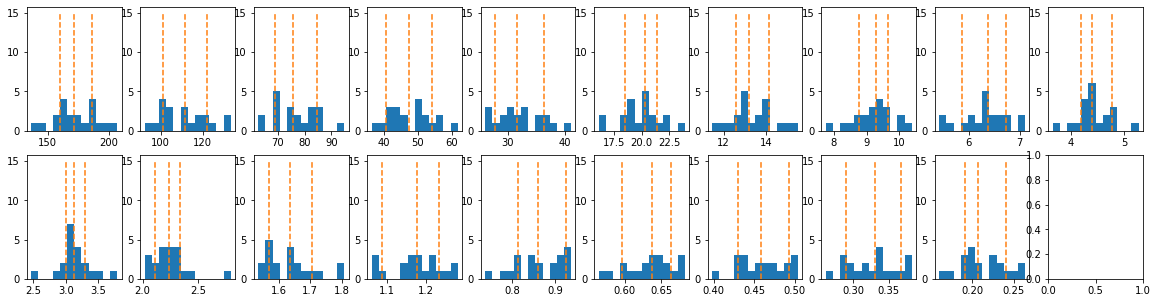

In [67]:
fig, ax = plt.subplots(2,10,figsize=(20,5))
ax=ax.reshape(-1)
med_xi100 = np.median(xi100, axis=0)
sigma_xi100 = (np.percentile(xi100, 75, axis=0) - np.percentile(xi100, 25, axis=0))*0.7413
med_xib = np.median(xi_b100, axis=0)
sigma_xib = (np.percentile(xi_b100, 75, axis=0) - np.percentile(xi_b100, 25, axis=0))*0.7413
med_xif = np.median(xi_f100, axis=0) 
sigma_xif = (np.percentile(xi_f100, 75, axis=0) - np.percentile(xi_f100, 25, axis=0))*0.7413
print(med_xi100)
print(sigma_xi100)
for i,j in enumerate(ax[:-1]):
    j.hist(xi100[:,i], bins=12) 
    j.vlines(med_xi100[i], 0, 15, ls='--', color='tab:orange')
    j.vlines(np.percentile(xi100[:,i], 84), 0, 15, ls='--', color='tab:orange')
    j.vlines(np.percentile(xi100[:,i], 16), 0, 15, ls='--', color='tab:orange')

[2.94927558 1.45316902] [[ 0.00382606 -0.00111574]
 [-0.00111574  0.00071733]]


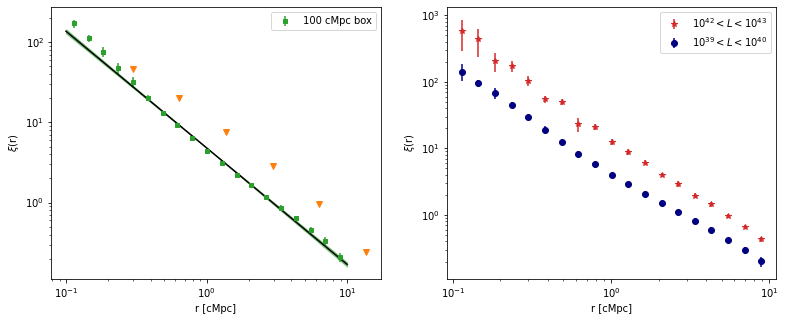

In [68]:
#plt.errorbar(bins_cen40, xi40, err_xi40, ls='', color='tab:red', marker='o', label='40 cMpc box')
fig, ax = plt.subplots(1,2, figsize = (13,5))
ax[0].errorbar(bins_cen100, med_xi100, sigma_xi100, ls='', color='tab:green', marker = 's', markersize=4,label='100 cMpc box')
ax[1].errorbar(bins_b100, med_xib, sigma_xib, ls='', color='tab:red', marker = '*', label=r'$10^{42} < L < 10^{43}$')
ax[1].errorbar(bins_f100, med_xif, sigma_xif, ls='', color='navy', marker = 'o', label=r'$10^{39} < L < 10^{40}$')
for i in ax:
    i.set_xscale('log')
    i.set_yscale('log')
    i.set_xlabel(r'r [cMpc]')
    i.set_ylabel(r'$\xi$(r)')
    i.legend()
#plt.ylim(0.2, 500)
xaxis= np.logspace(np.log10(bins[0]), np.log10(bins[-1]), 100)

def fit_f(r, r0, gamma):
    return (r0/r)**(gamma)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(fit_f, bins_cen100, med_xi100, p0=[2., 1.8], sigma=sigma_xi100)
print(popt, pcov)
sigma_popt = [np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1])]

ax[0].fill_between(xaxis, ((popt[0]+sigma_popt[0])/xaxis)**(popt[1]-sigma_popt[1]), ((popt[0]-sigma_popt[0])/xaxis)**(popt[1]+sigma_popt[1]), alpha=0.5, color='tab:green')
mack = np.genfromtxt('Mackenzie_corrdata.txt')
magg = np.genfromtxt('MAGG_LAE_corr.txt')

#plt.plot(magg[:,0]/(1000*cosmo.h), magg[:,1], ls='', marker='s', label='Magg')
ax[0].plot(mack[:,0], mack[:,1], ls='', marker='v', color='tab:orange', label='Mackenzie_2019')
ax[0].plot(xaxis, fit_f(xaxis, popt[0], popt[1]), label=r'$\xi$(r) = (%.2f/r)$^{%.2f}$' %(popt[0], popt[1]), color='black')

#plt.title('3D Correlation Function')

#plt.savefig('3D_corr_function.pdf', format='pdf', )

In [36]:
import emcee
from scipy import stats

def fit_f(r, r0, gamma):
    return (r0/r)**(gamma)

def loglike(par, r, xi, err_xi):
    log_l = -0.5*np.sum((fit_f(r, par[0], par[1]) - xi)**2/err_xi**2)
    return log_l

def prior(par):
    prior_r0 = stats.uniform.pdf(par[0], loc=1, scale=3)
    prior_g  = stats.uniform.pdf(par[1], loc=1.4, scale=0.8)
    return prior_r0*prior_g

def log_posterior(par, r, xi, err_xi):
    lp = np.log(prior(par))
    if not np.isfinite(lp):
        return -np.inf   #if the log_prior is not finite this put the log_posterior to -inf without giving errors
    else:
        return (loglike(par, r, xi, err_xi) + lp) #log_posterior = log_likelihood + log_prior
    

In [37]:
ndim = 2       # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
nsteps = 10000 # number of MCMC steps to take **for each walker**

starting_guesses = np.zeros([nwalkers, ndim])

#starting guesses estimated from the fit by hand
for i in range(nwalkers):
    starting_guesses[i,0] = np.random.uniform(1.7, 2.5)
    starting_guesses[i,1] = np.random.uniform(1.47, 1.9)

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[bins_cen100[:-5], med_xi100[:-5], sigma_xi100[:-5]])

sampler.run_mcmc(starting_guesses, nsteps)

# sampler.chain is of shape (nwalkers, nsteps, ndim)
emcee_trace  = sampler.chain.reshape(-1, ndim)

print("done")

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


done


In [38]:
autocorr_time = sampler.get_autocorr_time()
print(autocorr_time)

[37.17222639 35.89663759]


(10000, 6, 2)
(10000, 2)


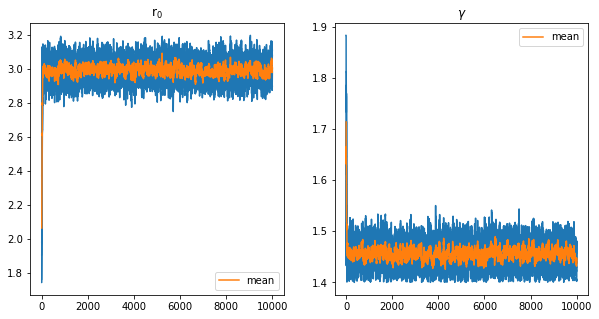

In [39]:
chains = sampler.get_chain()

meanch = np.mean(chains, axis=1)

print(chains.shape)
print(meanch.shape)

fig, ax = plt.subplots(1,ndim, figsize=(10,5))
titles = [r'r$_0$', r'$\gamma$']

for i in range(ndim):
    ax[i].plot(chains[:, :, i], c='tab:blue')
    ax[i].plot(meanch[:,i], c='tab:orange', label='mean')
    ax[i].legend()
    ax[i].set_title(titles[i])

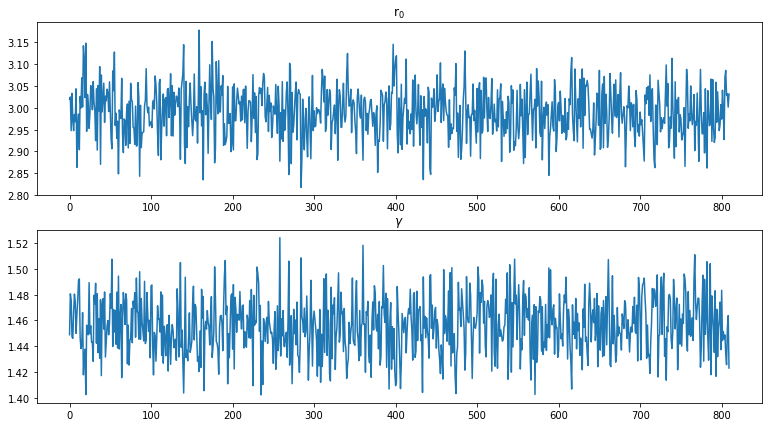

In [40]:
burn = 600
thin = 70  #I selected the highest auto-correlation time among the ones printed above, and multiply by 2 (more or less)

chains_flat = chains[burn::thin].reshape(-1, ndim)

fig, ax = plt.subplots(2,1, figsize=(13,7))
for i in range(ndim):
    ax[i].plot(chains_flat[:,i])
    ax[i].set_title(titles[i])

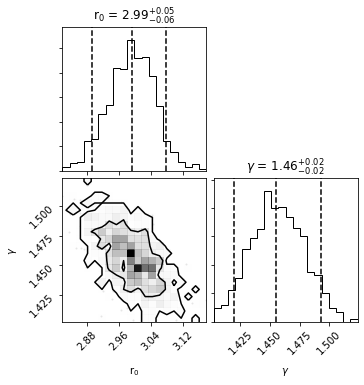

In [41]:
import corner
fig = corner.corner(chains_flat, levels=[0.68, 0.95] , quantiles=(0.05, 0.5, 0.95), labels=[r'r$_0$', r'$\gamma$'], 
                    title_quantiles=(0.05, 0.5, 0.95), show_titles=True)

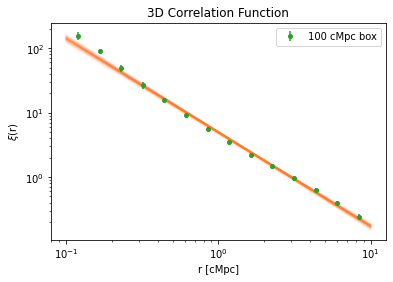

In [42]:
#plt.figure(figsize=(6,5))
plt.errorbar(bins_cen100[:-5], med_xi100[:-5], sigma_xi100[:-5], ls='', color='tab:green', marker = 'o', markersize=4,label='100 cMpc box')
plt.xscale('log')
plt.yscale('log')
#plt.ylim(0.2, 500)
xaxis= np.logspace(np.log10(bins[0]), np.log10(10), 100)

index_par = np.random.randint(low=0, high=len(chains_flat), size=200, dtype=int)
random_samples = chains_flat[index_par]
for i in range(len(random_samples)):
    plt.plot(xaxis, fit_f(xaxis, random_samples[i,0], random_samples[i,1]), alpha = 0.01, c='tab:orange')
#plt.plot(xaxis, fit_f(xaxis, popt[0], popt[1]), label=r'$\xi$(r) = (%.2f/r)$^{%.2f}$' %(popt[0], popt[1]))
plt.xlabel(r'r [cMpc]')
plt.ylabel(r'$\xi$(r)')
plt.legend()
plt.title('3D Correlation Function')

plt.savefig('corr_mcmcfit.pdf', format='pdf')

In [43]:
#test with a uniform distiribution

xi_uni = np.zeros((N_boot, len(bins)-1))
pos_uni = np.random.uniform(0, 100, size=(len(Pos_Mpc_corr), 3))
for i in range(N_boot):
    bins_uni, xi_uni[i], _ = corr_func(500, bins, pos_uni, 0, 100, False)


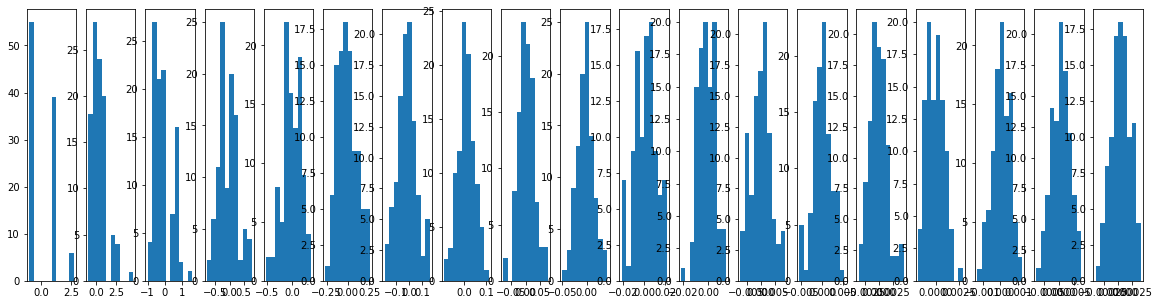

In [44]:
fig, ax = plt.subplots(1,len(bins)-1, figsize=(20,5))
for i,j in enumerate(ax):
    j.hist(xi_uni[:,i], bins=10)

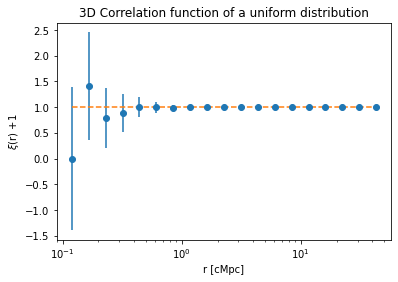

In [45]:
sigma_xiuni = 0.7413*(np.percentile(xi_uni, 75, axis=0) - np.percentile(xi_uni, 25, axis=0))
plt.errorbar(bins_uni, np.median(xi_uni, axis=0)+1, sigma_xiuni, linestyle='', marker='o')
#print(xi_uni+1)
#print(np.min(pos_uni), np.max(pos_uni))
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(0.3, 10)

xxx = np.linspace(bins_uni[0], bins_uni[-1], 2)
plt.plot(xxx, xxx*0+1, ls='--')
#plt.ylim(0.9,1.1)
plt.title('3D Correlation function of a uniform distribution')
plt.xlabel('r [cMpc]')
plt.ylabel(r'$\xi$(r) +1')
plt.savefig('3D_corr_uniform.pdf', format='pdf')